In [1]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python")
import src.misc_plotting as plotting
import src.utils as utils
import src.model_eval as eval
import src.isingfitter as fitter

import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [2]:
num_units = 60
num_sims = 30_000
num_burn = 1000

In [14]:
##############
# SIMULATION #
##############

# setting up model
beta = 1.3
h = np.random.uniform(-3, 3, num_units)

J_IP = np.zeros((num_units, num_units))
if num_units % 2 == 0:
    pairs = np.split(np.random.permutation(num_units), num_units / 2)
else:
    pairs = np.split(np.random.permutation(num_units - 1), (num_units - 1) / 2)
for pair in pairs:
    J_IP[pair[0]][pair[1]] = np.random.uniform(-1 / np.sqrt(num_units), 1 / np.sqrt(num_units))
    J_IP[pair[1]][pair[0]] = J_IP[pair[0]][pair[1]]

true_model = ising.EqModel(J_IP, h)

# simulating
true_sim = true_model.simulate(num_sims, num_burn)

In [35]:
def get_chi_pair(h, J, i, j):
    num = (
        np.exp(h[i] + h[j] + J[i,j]) 
        - np.exp(h[i] - h[j] - J[i,j]) 
        - np.exp(-h[i] + h[j] - J[i,j]) 
        + np.exp(-h[i] - h[j] + J[i,j])
    )
    den = (
        np.exp(h[i] + h[j] + J[i,j]) 
        + np.exp(h[i] - h[j] - J[i,j]) 
        + np.exp(-h[i] + h[j] - J[i,j]) 
        + np.exp(-h[i] - h[j] + J[i,j])
    )  
    return num / den

def get_m_pair(h, J, i, j):
    num = (
        np.exp(h[i] + h[j] + J[i,j]) 
        + np.exp(h[i] - h[j] - J[i,j]) 
        - np.exp(-h[i] + h[j] - J[i,j]) 
        - np.exp(-h[i] - h[j] + J[i,j])
    )
    den = (
        np.exp(h[i] + h[j] + J[i,j]) 
        + np.exp(h[i] - h[j] - J[i,j]) 
        + np.exp(-h[i] + h[j] - J[i,j]) 
        + np.exp(-h[i] - h[j] + J[i,j])
    )
    return num / den

def get_analytic_pcorrs(h: np.ndarray, J: np.ndarray, pairs: list) -> np.ndarray:
    num_units = h.shape[0]
    chi = np.ones((num_units, num_units))
    for i in range(num_units):
        for j in [k for k in range(num_units) if k != i]:
            chi[i, j] = np.tanh(h[i]) * np.tanh(h[j])
    
    for (i, j) in pairs:
        chi[i, j] = get_chi_pair(h, J, i, j)
        chi[j, i] = chi[i, j]
    
    return chi

def get_analytic_means(h: np.ndarray, J: np.ndarray, pairs: list) -> np.ndarray:
    num_units = h.shape[0]
    m = np.array([np.tanh(h[i]) for i in range(num_units)])

    for (i, j) in pairs:
        m[i] = get_m_pair(h, J, i, j)
        m[j] = get_m_pair(h, J, j, i)

    return m


chi_analytic = get_analytic_pcorrs(h, J_IP, pairs)
m_analytic = get_analytic_means(h, J_IP, pairs)

Text(0, 0.5, 'Empirical')

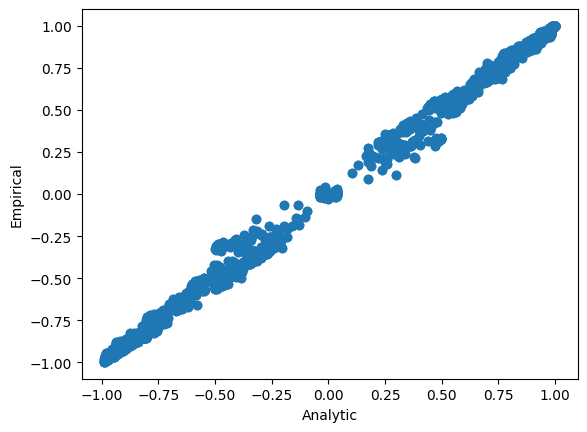

In [36]:
plt.scatter(chi_analytic, true_sim.getPairwiseCorrs())
plt.xlabel("Analytic")
plt.ylabel("Empirical")

Text(0, 0.5, 'Empirical')

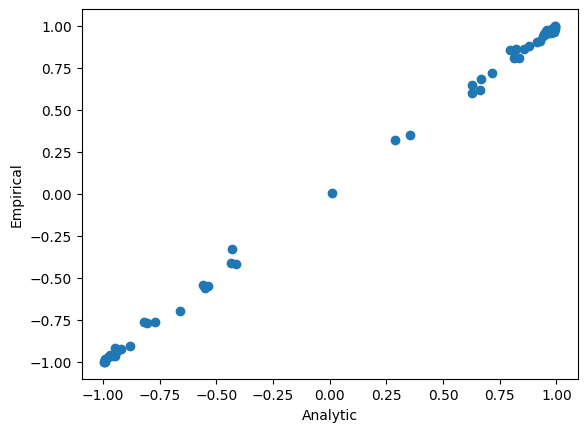

In [37]:
plt.scatter(m_analytic, true_sim.getMeans())
plt.xlabel("Analytic")
plt.ylabel("Empirical")

### TO-DO: 
- confirm equation for chi_analytic, and derive equation for m_analytic
- make scatter plots
- plot sensitivity curves